# Quick assessment on non-single-cell Mphi death

In [1]:
import napari
from macrohet import dataio, tile, tools, visualise
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os 

colors = sns.color_palette('PiYG')
sns.set_theme(style = 'white')
sns.set(font='Nimbus Sans', style = 'white')

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iterate over GFP images, measuring total GFP signal

In [6]:
gfp_df = pd.DataFrame({}, columns = assay_layout.index)


In [7]:
image_dir = '/mnt/DATA/macrohet/macrohet_images/Images'

'/mnt/DATA/macrohet/macrohet_images/Images'

In [8]:
for i, line in tqdm(enumerate(assay_layout.iterrows()), total = len(assay_layout)):
        strain = line[1]['Strain']
        compound = line[1]['Compound']
        conc = line[1]['Concentration']
        name = f'{strain, compound, conc}'
        row, column = line[0]

        images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane='sum_proj', 
                             set_channel = 1,
                             )
        gfp_signals = []
        for t in tqdm(range(0,len(images)), leave = False):
            try:
                frame = images[t].compute().compute()
                gfp_signal = np.sum(frame)
            except Exception as e:
                print(f'Could not load frame {t} row, col {line[0]}')
                print(e)
                gfp_signal = None
            gfp_signals.append(gfp_signal)
        gfp_df[line[0]] = gfp_signals
        gfp_df.to_csv('gfp_signals.csv')

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [10]:
palette = sns.color_palette('PiYG')#rocket')
palette

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

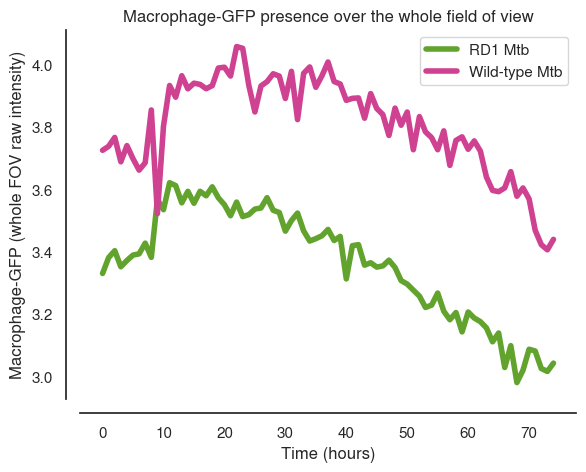

In [12]:
sns.lineplot(data = gfp_df[(3,4)]/1.55E10, label = 'RD1 Mtb', linewidth = 4, color = palette[5]
#                       palette = 'rocket_r'
                  )
sns.lineplot(data = gfp_df[(3,5)]/1.55E10, label ='Wild-type Mtb', linewidth = 4, color = palette[0])
sns.despine(offset=10) # the important part here
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Macrophage-GFP (whole FOV raw intensity)')
plt.title('Macrophage-GFP presence over the whole field of view')# (Replication_IPSDM_GFP dataset)')
# fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_macrophage_growth/whole_fov_macrophage_growth_row_WT_RD1.png', bbox_inches = 'tight', dpi = 314)

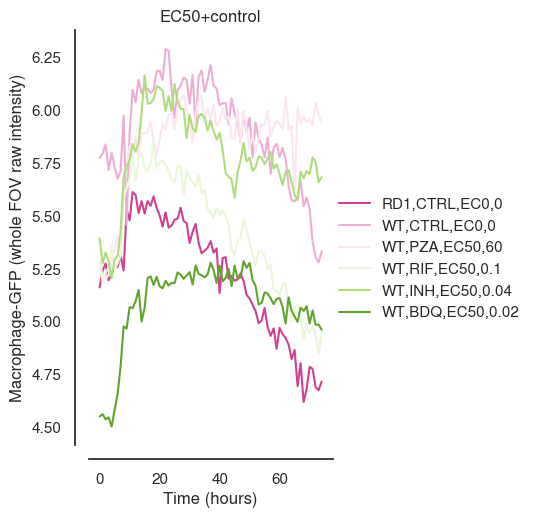

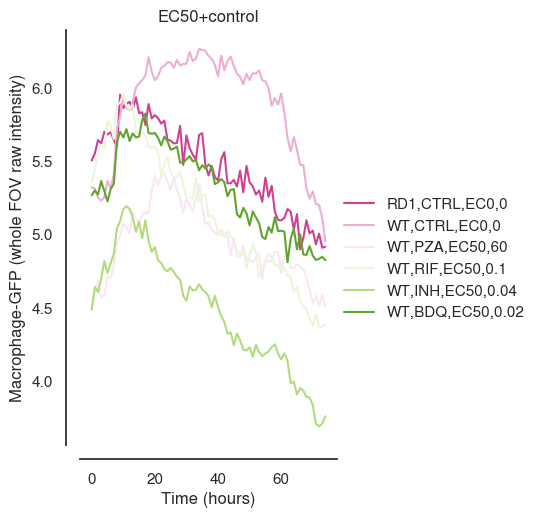

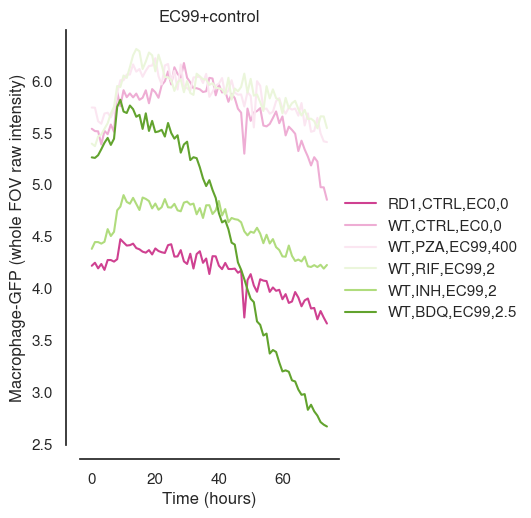

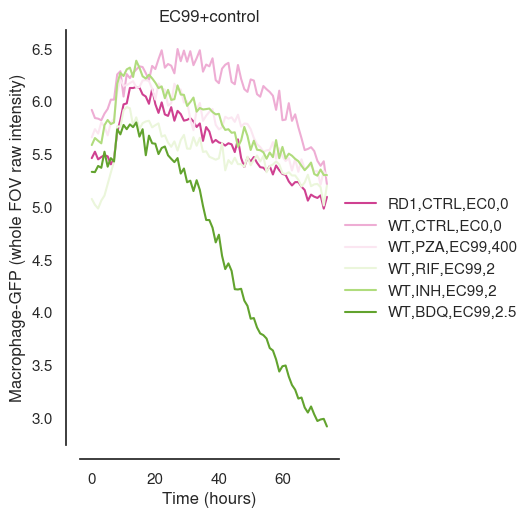

In [14]:
plots = dict()
plot_dfs = dict()
for n, (row, conc_EC_df) in enumerate((assay_layout.groupby(level=0))):
    max_vals = list()
    conc_grouped_df = pd.DataFrame()
    for row, column in conc_EC_df.index:
        info = conc_EC_df.loc[(row, column)]
        strain = info['Strain']
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        conc_grouped_df[label] = gfp_df[(row,column)]
    plot_dfs[n] = conc_grouped_df
    fig = sns.relplot(
        data=conc_grouped_df/1E10,
        kind="line", 
        palette=palette,
#         height=3, aspect=2, dashes=False
        height=5, aspect=0.75, dashes=False

    )
    sns.despine(offset=10)
    plt.ylabel('Macrophage-GFP (whole FOV raw intensity)')
    plt.xlabel('Time (hours)')
    plt.title(ec_conc+ '+control')
    
    plots[(row,column)] = fig

# Import custom colour maps

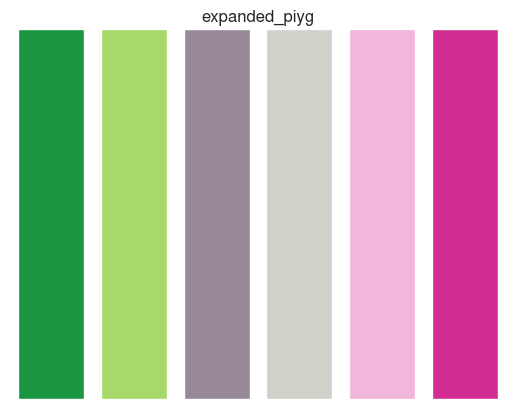

In [15]:
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')

/tmp/ipykernel_1061244/3316551517.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


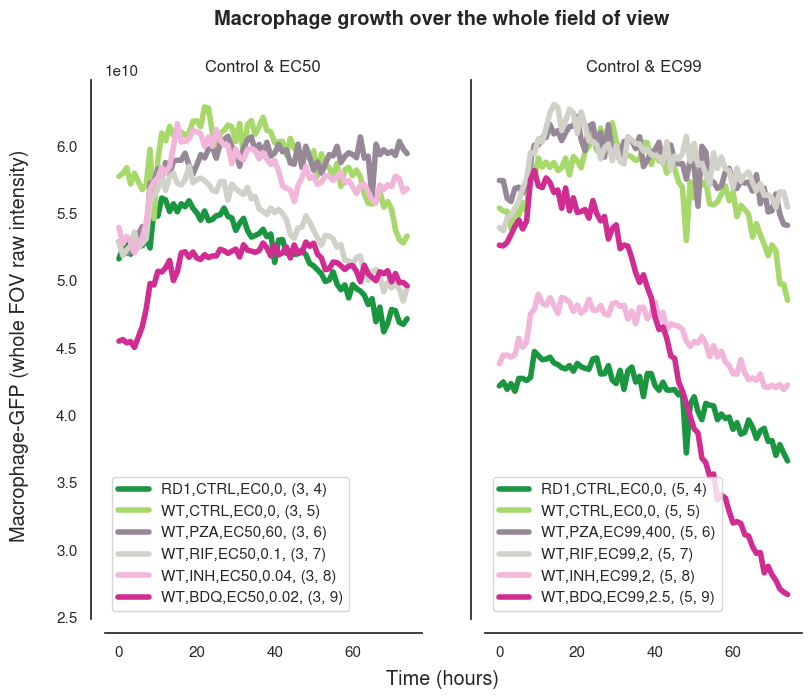

In [16]:
# Set the new color palette
sns.set_palette(expanded_piyg.colors)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

for n, i in enumerate(plot_dfs[0].items()):
    label = i[0] + f', (3, {n+4})'
    LHS = sns.lineplot(data=i[1], ax=ax[0], label=label, linewidth=4)
    sns.despine(ax=ax[0], offset=0)

LHS.set(ylabel=None)

for n, i in enumerate(plot_dfs[2].items()):
    label = i[0] + f', (5, {n+4})'
    sns.lineplot(data=i[1], ax=ax[1], label=label, linewidth=4)
    sns.despine(ax=ax[1], offset=0)

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Macrophage-GFP (whole FOV raw intensity)')
plt.suptitle('Macrophage growth over the whole field of view', fontweight='bold')
sns.despine(offset=10)
fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_macrophage_growth/whole_fov_macrophage_growth_row3&5.png', bbox_inches='tight', dpi=314)


/tmp/ipykernel_1061244/2754507270.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


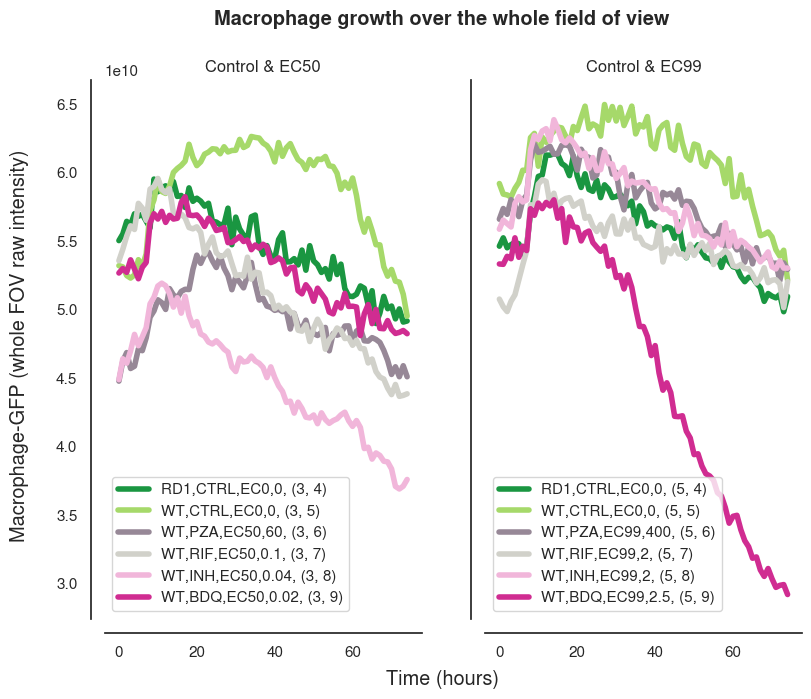

In [17]:
# Set the new color palette
sns.set_palette(expanded_piyg.colors)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

for n, i in enumerate(plot_dfs[1].items()):
    label = i[0] + f', (3, {n+4})'
    LHS = sns.lineplot(data=i[1], ax=ax[0], label=label, linewidth=4)
    sns.despine(ax=ax[0], offset=0)

LHS.set(ylabel=None)

for n, i in enumerate(plot_dfs[3].items()):
    label = i[0] + f', (5, {n+4})'
    sns.lineplot(data=i[1], ax=ax[1], label=label, linewidth=4)
    sns.despine(ax=ax[1], offset=0)

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Macrophage-GFP (whole FOV raw intensity)')
plt.suptitle('Macrophage growth over the whole field of view', fontweight='bold')
sns.despine(offset=10)
fig.show()
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_macrophage_growth/whole_fov_macrophage_growth_row4&6.png', bbox_inches='tight', dpi=314)


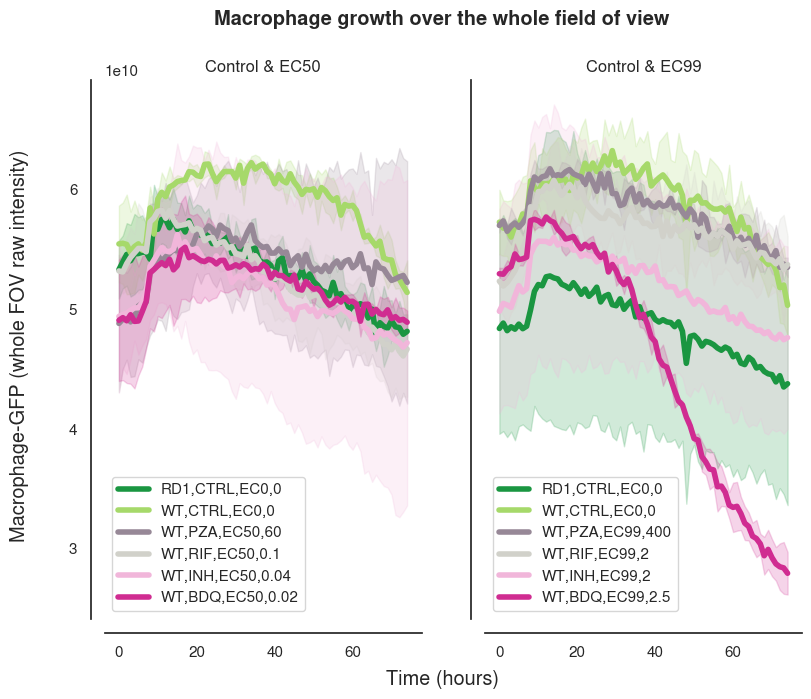

In [18]:
# Set the new color palette
sns.set_palette(expanded_piyg.colors)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

for n, (i, j) in enumerate(zip(plot_dfs[1].items(), plot_dfs[0].items())):
    # Combine original and repeat data into one DataFrame
    combined = pd.concat([i[1], j[1]])
    label = i[0]
    LHS = sns.lineplot(data=combined, ax=ax[0], label=label, linewidth=4, ci='sd')
    sns.despine(ax=ax[0], offset=0)

LHS.set(ylabel=None)

for n, (i, j) in enumerate(zip(plot_dfs[3].items(), plot_dfs[2].items())):
    # Combine original and repeat data into one DataFrame
    combined = pd.concat([i[1], j[1]])
    label = i[0]
    sns.lineplot(data=combined, ax=ax[1], label=label, linewidth=4, ci='sd')
    sns.despine(ax=ax[1], offset=0)

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Macrophage-GFP (whole FOV raw intensity)')
plt.suptitle('Macrophage growth over the whole field of view', fontweight='bold')
sns.despine(offset=10)
# Save the figure
plt.savefig('/mnt/DATA/macrohet/results/whole_fov_macrophage_growth/whole_fov_macrophage_growth_all_row.png', bbox_inches='tight', dpi=314)

# Show the figure
plt.show()
